# **SINGLE CLASS-EMPTY MODEL**
The single class-Empty model detects and classifies objects in images that have items missing on their shelvs, as 'Empty'. It processes input images, predicts bounding boxes for detected objects, and assigns a class label to each object, facilitating for out-of-stock detection for retail stores using Computer Vision

## **IMPORTING LIBRARIES**

In [11]:
import os
import json
from PIL import Image
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **DATA LOADING AND PREPARATION**

In [12]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Path to datasets
images_dir = '/content/drive/MyDrive/IProject/Train/Images'
annotations_dir = '/content/drive/MyDrive/IProject/Train/Annotations'

# Categories mapping for single-class model
# categories = {'Empty': 1, 'Organized': 0}



### This code block loads the train and processes the train data
 `load_annotations`: Load and normalize annotation labels and bounding boxes.
`preprocess_image`: Resize and normalize image for model input.

In [14]:
def load_annotations(annotation_path, image_size):
    """
    Load annotations from a JSON file and normalize bounding box coordinates.

    Parameters:
    - annotation_path: str, path to the annotation JSON file.
    - image_size: tuple, dimensions of the image (height, width).

    Returns:
    - labels: list, normalized labels corresponding to annotations.
    - bboxes: list, normalized bounding box coordinates.
    """
    with open(annotation_path, 'r') as file:
        annotations = json.load(file)  # Load annotations from the JSON file

    labels = []  # List to store labels
    bboxes = []  # List to store bounding boxes

    for annotation in annotations:
        for ann in annotation['annotations']:
            label = ann['label']
            if label is None:  # Skip annotations with unrecognized labels
                continue
            x, y, width, height = ann['coordinates'].values()  # Extract bounding box coordinates

            # Normalize bounding box coordinates
            norm_x = x / image_size[1]
            norm_y = y / image_size[0]
            norm_width = width / image_size[1]
            norm_height = height / image_size[0]

            labels.append(0)  # Append 'Empty' class label (single class)
            bboxes.append([norm_x, norm_y, norm_width, norm_height])  # Append the normalized bounding box

    return labels, bboxes


def preprocess_image(image_path):
    """
    Preprocess an image for model input by resizing and normalizing pixel values.

    Parameters:
    - image_path: str, path to the image file.

    Returns:
    - image_data: np.array, preprocessed image data ready for model input.
    """
    image = Image.open(image_path)  # Open the image file
    image = image.resize((300, 300))  # Resize the image to 300x300 pixels
    image_data = np.array(image)  # Convert the image to a numpy array
    image_data = preprocess_input(image_data)  # Normalize the pixel values
    return image_data


### Padding and one-hot encode labels, pad bounding boxes for annotations.

In [15]:
import numpy as np
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input

def pad_annotations(labels, bboxes, max_objects=20, num_classes=1):
    """
    Pad labels and bounding boxes to a fixed size.

    Parameters:
    - labels: list, list of labels for an image.
    - bboxes: list, list of bounding boxes for an image.
    - max_objects: int, maximum number of objects to pad (default is 20).
    - num_classes: int, number of classes for one-hot encoding (default is 1).

    Returns:
    - padded_labels: np.array, array of one-hot encoded labels with padding.
    - padded_bboxes: np.array, array of bounding boxes with padding.
    """
    padded_labels = np.zeros((max_objects, num_classes), dtype=np.float32)  # Initialize padded labels array
    padded_bboxes = np.zeros((max_objects, 4), dtype=np.float32)  # Initialize padded bounding boxes array

    num_labels = len(labels)  # Number of labels
    for i in range(min(num_labels, max_objects)):
        padded_labels[i, 0] = 1  # Single-class label
        padded_bboxes[i] = bboxes[i]  # Copy bounding box

    return padded_labels, padded_bboxes

### Create padded dataset from images and annotations, including labels, bounding boxes, filenames, and object counts.

In [16]:
def create_padded_dataset(images_dir, annotations_dir, image_size=(300, 300), max_objects=20):
    """
    Create a dataset with padded annotations from images and their corresponding annotations.

    Parameters:
    - images_dir: str, directory containing the images.
    - annotations_dir: str, directory containing the annotation JSON files.
    - image_size: tuple, target size for resizing images (default is (300, 300)).
    - max_objects: int, maximum number of objects to pad (default is 20).

    Returns:
    - data: np.array, array of preprocessed images.
    - class_labels: np.array, array of one-hot encoded labels with padding.
    - bboxes: np.array, array of padded bounding boxes.
    - filenames: list, list of filenames for each image.
    - object_counts: np.array, array of object counts for each image.
    """
    data = []  # List to store preprocessed images
    class_labels = []  # List to store padded labels
    bboxes = []  # List to store padded bounding boxes
    filenames = []  # List to store filenames
    object_counts = []  # List to store object counts

    for image_file in os.listdir(images_dir):
        image_path = os.path.join(images_dir, image_file)
        processed_image = preprocess_image(image_path)

        annotation_file = image_file.replace('.png', '.json')  # Find the corresponding annotation file
        annotation_path = os.path.join(annotations_dir, annotation_file)  # Construct full path to the annotation file

        if os.path.exists(annotation_path):
            image_labels, image_bboxes = load_annotations(annotation_path, image_size)  # Load annotations if the file exists
            if not image_labels:  # Check if image_labels list is empty after processing
                continue  # Skip this image if no valid annotations were found

            padded_labels, padded_bboxes = pad_annotations(image_labels, image_bboxes, max_objects, num_classes=1)  # Pad annotations
            data.append(processed_image)  # Append the processed image to the data list
            class_labels.append(padded_labels)  # Append the padded labels to the class_labels list
            bboxes.append(padded_bboxes)  # Append the padded bounding boxes to the bboxes list
            filenames.append(image_file)  # Append the filename to the filenames list
            object_counts.append(len(image_labels))  # Append the object count to the object_counts list
        else:
            continue  # Skip images without annotations

    return np.array(data), np.array(class_labels), np.array(bboxes), filenames, np.array(object_counts)

## **MODEL BUILDING**

### Creating the ResNet50 pre-trained model backbone for Transfer Learning

In [17]:
def create_resnet50_backbone(input_shape, max_objects=20, num_classes=1, rate=0.01):
    """
    Create a ResNet50-based model for object detection with bounding box and class outputs.

    Parameters:
    - input_shape: tuple, shape of the input images (height, width, channels).
    - max_objects: int, maximum number of objects per image (default is 20).
    - num_classes: int, number of classes for classification (default is 1).
    - rate: float, regularization rate for the dense layer (default is 0.01).

    Returns:
    - model: keras.Model, compiled model with ResNet50 backbone and custom outputs.
    """
    # Loading the ResNet50 model with pretrained weights, excluding the top layer
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freezing all layers except the last 50 layers for fine-tuning
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    # Adding custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = BatchNormalization()(x)  # Batch normalization layer
    x = Dense(1024, activation='relu', kernel_regularizer=l2(rate))(x)  # Dense layer with L2 regularization
    x = Dropout(0.8)(x)  # Dropout layer to prevent overfitting

    # Defining the output layer for bounding box predictions
    num_bbox_outputs = max_objects * 4
    bbox_output = Dense(num_bbox_outputs, activation='sigmoid')(x)  # Dense layer with sigmoid activation
    bbox_output = Reshape((max_objects, 4), name='bbox_output')(bbox_output)  # Reshape output to (max_objects, 4)

    # Defining the output layer for class predictions
    num_class_outputs = max_objects * num_classes
    class_output = Dense(num_class_outputs, activation='sigmoid')(x)  # Dense layer with sigmoid activation
    class_output = Reshape((max_objects, num_classes), name='class_output')(class_output)  # Reshape output to (max_objects, num_classes)

    # Creating the final model
    model = Model(inputs=base_model.input, outputs=[bbox_output, class_output])

    return model

### This `combined_generator` function to generate batches of images with corresponding class labels and bounding boxes

In [18]:
def combined_generator(image_gen, class_labels, bboxes, max_objects, num_classes):
    """
    Generate batches of images and their corresponding labels and bounding boxes.

    Parameters:
    - image_gen: ImageDataGenerator, generator for image batches.
    - class_labels: np.array, array of class labels.
    - bboxes: np.array, array of bounding boxes.
    - max_objects: int, maximum number of objects per image.
    - num_classes: int, number of classes for classification.

    Returns:
    - image_batch: np.array, batch of images.
    - dict: dictionary containing class labels and bounding boxes.
    """
    while True:
        image_batch = next(image_gen)  # Getting the next batch of images
        batch_size = image_batch.shape[0]  # Get the batch size
        class_labels_batch = np.zeros((batch_size, max_objects, num_classes), dtype=np.float32)  # Initialize batch for class labels
        bboxes_batch = np.zeros((batch_size, max_objects, 4), dtype=np.float32)  # Initialize batch for bounding boxes
        for i in range(batch_size):
            idx = (image_gen.batch_index - 1) * image_gen.batch_size + i
            if idx < len(class_labels):
                class_labels_batch[i] = class_labels[idx]  # Assign class labels to batch
                bboxes_batch[i] = bboxes[idx]  # Assign bounding boxes to batch
        yield image_batch, {'class_output': class_labels_batch, 'bbox_output': bboxes_batch}

### Functions to create compile and train the model using images and annotations from specified directories.

In [19]:
def compile_and_train_model(model, images_dir, annotations_dir, max_objects=20, epochs=40):
    """
    Compile and train the model using the specified directories for images and annotations.

    Parameters:
    - model: keras.Model, the model to be trained.
    - images_dir: str, directory containing the images.
    - annotations_dir: str, directory containing the annotation JSON files.
    - max_objects: int, maximum number of objects per image (default is 20).
    - epochs: int, number of epochs for training (default is 30).

    Returns:
    - history: keras.callbacks.History, history of the training process.
    """
    # Create padded dataset from images and annotations
    data, class_labels, bboxes, filenames, object_counts = create_padded_dataset(images_dir, annotations_dir, max_objects=max_objects)

    # Flatten the class labels to determine if an image contains any objects (binary: 0 or 1)
    flat_labels = [1 if np.sum(cls) > 0 else 0 for cls in class_labels]
    # Flatten the image data to a 2D array for oversampling
    data_flat = data.reshape(data.shape[0], -1)

    # Check if there is more than one class to perform oversampling
    if len(np.unique(flat_labels)) > 1:
        # Apply RandomOverSampler to balance the classes
        ros = RandomOverSampler()
        data_resampled, flat_labels_resampled = ros.fit_resample(data_flat, flat_labels)

        # Reshape the resampled data back to its original shape
        data_resampled = data_resampled.reshape(-1, *data.shape[1:])
        # Resample the class labels and bounding boxes according to the oversampled indices
        class_labels_resampled = np.array([class_labels[i] for i in ros.sample_indices_])
        bboxes_resampled = np.array([bboxes[i] for i in ros.sample_indices_])
    else:
        # If only one class, no resampling is needed
        data_resampled = data
        class_labels_resampled = class_labels
        bboxes_resampled = bboxes

    # Compile the model with specified optimizer, loss functions, and metrics
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss={'bbox_output': 'mse', 'class_output': 'binary_crossentropy'},
        metrics={'bbox_output': 'mse', 'class_output': 'accuracy'}
    )

    # Define callbacks for saving the best model and early stopping to avoid overfitting
    checkpoint = ModelCheckpoint('/content/drive/MyDrive/IProject/Trained_Models/Best Model.keras', save_best_only=True, monitor='class_output_loss', mode='min')
    early_stopping = EarlyStopping(patience=10, monitor='class_output_loss', mode='min', restore_best_weights=True)

    # Create an image data generator with augmentation parameters to enhance the training dataset
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    # Create a data generator that yields batches of augmented images and their corresponding labels and bounding boxes
    data_generator = datagen.flow(data_resampled, batch_size=16, shuffle=True)
    combined_gen = combined_generator(data_generator, class_labels_resampled, bboxes_resampled, max_objects, num_classes=1)

    # Train the model using the combined generator
    history = model.fit(
        combined_gen,  # Training data generator
        steps_per_epoch=len(data_resampled) // 64,  # Number of steps per epoch
        epochs=epochs,  # Number of epochs to train the model
        validation_data=(data_resampled, {'class_output': class_labels_resampled, 'bbox_output': bboxes_resampled}),  # Validation data
        callbacks=[checkpoint, early_stopping]  # Callbacks for checkpointing and early stopping
    )

    return history  # Return the history of the training process

### Training The Model

In [20]:
# Example usage
input_shape = (300, 300, 3)  # Define the input shape of the images
model = create_resnet50_backbone(input_shape)  # Create the ResNet50-based model
train_data_dir = '/content/drive/MyDrive/IProject/Train/Images'  # Define the directory for training images
train_annotations_dir = '/content/drive/MyDrive/IProject/Train/Annotations'  # Define the directory for training annotations
compile_and_train_model(model, train_data_dir, train_annotations_dir)  # Compile and train the model

Epoch 1/40
8/8 [==============================] - 296s 39s/step - loss: 14.9549 - bbox_output_loss: 0.3118 - class_output_loss: 1.1098 - bbox_output_mse: 0.3118 - class_output_accuracy: 0.5512 - val_loss: 14.2269 - val_bbox_output_loss: 0.2088 - val_class_output_loss: 0.6228 - val_bbox_output_mse: 0.2088 - val_class_output_accuracy: 0.6496
Epoch 2/40
8/8 [==============================] - 283s 39s/step - loss: 14.5054 - bbox_output_loss: 0.2852 - class_output_loss: 0.9224 - bbox_output_mse: 0.2852 - class_output_accuracy: 0.6027 - val_loss: 13.9296 - val_bbox_output_loss: 0.1798 - val_class_output_loss: 0.5752 - val_bbox_output_mse: 0.1798 - val_class_output_accuracy: 0.6996
Epoch 3/40
8/8 [==============================] - 282s 39s/step - loss: 14.2255 - bbox_output_loss: 0.2585 - class_output_loss: 0.8857 - bbox_output_mse: 0.2585 - class_output_accuracy: 0.6160 - val_loss: 13.6515 - val_bbox_output_loss: 0.1530 - val_class_output_loss: 0.5366 - val_bbox_output_mse: 0.1530 - val_clas

## **Model Prediction**

### Loading and Preparing the test data

In [21]:
# Load the test dataset
test_images_dir = '/content/drive/MyDrive/IProject/Test/Images'
test_annotations_dir = '/content/drive/MyDrive/IProject/Test/Annotations'

# Using the already defined create_padded_dataset to prepare the data
test_images, test_labels, test_bboxes, test_filenames, object_counts = create_padded_dataset(test_images_dir, test_annotations_dir)

# Counting the frequency of labels
def count_labels(test_labels, object_counts):
    label_counts = {'Empty': 0}

    for labels, count in zip(test_labels, object_counts):
        for i in range(count):  # Iterate through each object's labels up to the actual object count
            if labels[i][0] == 1:  # Check if the single-class label is present
                label_counts['Empty'] += 1

    return label_counts

label_counts = count_labels(test_labels, object_counts)
print("Label counts:", label_counts)

Label counts: {'Empty': 523}


### Loading the model, extraxting the model predictions and getting the frequency of model label predictions

In [22]:
import numpy as np
from keras.models import load_model

# Loading the trained model
model = load_model('/content/drive/MyDrive/IProject/Trained_Models/ABBest_Model.keras')

# Predict using the model
predictions = model.predict(test_images)
bbox_predictions, class_predictions = predictions[0], predictions[1]

# Function to count predicted labels
def count_predicted_labels(predicted_labels, object_counts):
    label_counts = {'Empty': 0}

    for labels, count in zip(predicted_labels, object_counts):
        for i in range(count):  # Iterate through each object's labels up to the actual object count
            if labels[i][0] == 1:  # Check if the single-class label is present
                label_counts['Empty'] += 1

    return label_counts

# Function to denormalize bounding boxes
def denormalize_bounding_boxes(bboxes, original_width, original_height):
    denormalized_bboxes = []
    for bbox in bboxes:
        x, y, width, height = bbox
        denormalized_bboxes.append([
            x * original_width,
            y * original_height,
            width * original_width,
            height * original_height
        ])
    return denormalized_bboxes

# Initialize the count for predicted labels
predicted_label_counts = {'Empty': 0}

# Iterate over each test sample and print the results
for i in range(len(test_filenames)):
    # Get the predicted bounding boxes and class scores for this image
    predicted_bboxes = bbox_predictions[i]
    predicted_scores = class_predictions[i]

    # Denormalize bounding boxes (assuming the original image size is 300x300)
    denormalized_bboxes = denormalize_bounding_boxes(predicted_bboxes, 300, 300)

    for j in range(object_counts[i]):  # Only consider the actual objects, ignore padding
        bbox = denormalized_bboxes[j]
        class_score = predicted_scores[j]

        # Get the predicted class label and its score
        predicted_class_label = 'Empty' if class_score[0] >= 0.5 else 'Not Empty'
        predicted_class_score = class_score[0]

        # Update the count for the predicted label if it is 'Empty'
        if predicted_class_label == 'Empty':
            predicted_label_counts['Empty'] += 1

print(f"Predicted Label Counts: {predicted_label_counts}")

4/4 [==============================] - 54s 13s/step
Predicted Label Counts: {'Empty': 390}


## **Evaluation**

### Precision-Recall Curve
A precision-recall curve evaluates the model by visualizing the trade-off between precision and recall at a 0.5 threshold in the classification model. Precision, the ratio of true positive predictions to the total predicted positives, and recall, the ratio of true positives to all actual positives, are used to evaluate the model. The Intersection over Union (IoU) for bounding boxes, along with true positives, false positives, and false negatives, is calculated. The precision-recall curves for each category, providing Average Precision (AP) values, visualize the model's performance on 'Disorganized' and 'Empty' classes.

Precision: 0.92, Recall: 0.14


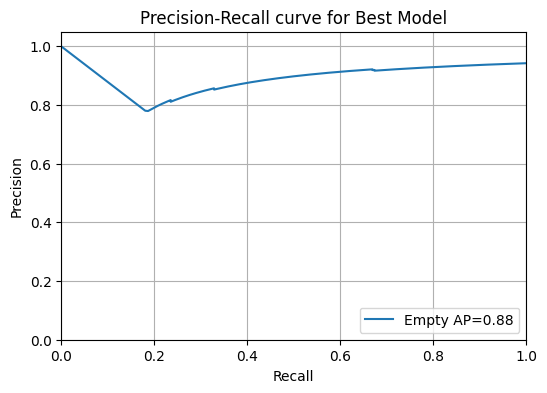

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Function to calculate Intersection over Union (IoU)
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Function to count true positives, false positives, and false negatives based on IoU threshold
def count_detections(true_bboxes, predicted_bboxes, predicted_labels, object_counts, iou_threshold=0.5):
    tp, fp, fn = 0, 0, 0

    for i in range(len(true_bboxes)):
        true_boxes = true_bboxes[i]
        pred_boxes = predicted_bboxes[i]
        true_count = len(true_boxes)
        pred_count = object_counts[i]

        matched = np.zeros(true_count, dtype=bool)

        for j in range(pred_count):
            pred_box = pred_boxes[j]
            pred_label = predicted_labels[i][j][0] >= 0.5  # Check if predicted label is 'Empty'

            if pred_label:
                for k in range(true_count):
                    if matched[k]:
                        continue
                    iou = calculate_iou(pred_box, true_boxes[k])
                    if iou >= iou_threshold:
                        matched[k] = True
                        tp += 1
                        break
                else:
                    fp += 1

        fn += np.sum(~matched)

    return tp, fp, fn

# Calculating metrics including bounding box predictions
def calculate_bbox_metrics(true_bboxes, predicted_bboxes, predicted_labels, object_counts, iou_threshold=0.5):
    tp, fp, fn = count_detections(true_bboxes, predicted_bboxes, predicted_labels, object_counts, iou_threshold)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return precision, recall

precision, recall = calculate_bbox_metrics(test_bboxes, bbox_predictions, class_predictions, object_counts)

# Printing the results
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

# Plotting Precision-Recall curve
def plot_bbox_precision_recall_curve(true_bboxes, predicted_bboxes, predicted_labels, object_counts, iou_threshold=0.5):
    plt.figure(figsize=(6, 4))

    # Creating binary labels for the 'Empty' category based on IoU threshold
    true_binary_labels = []
    predicted_scores = []

    for i in range(len(true_bboxes)):
        true_boxes = true_bboxes[i]
        pred_boxes = predicted_bboxes[i]
        pred_labels = predicted_labels[i]
        true_count = len(true_boxes)
        pred_count = object_counts[i]

        for j in range(pred_count):
            pred_box = pred_boxes[j]
            score = pred_labels[j][0]  # Confidence score for 'Empty'
            best_iou = 0

            for k in range(true_count):
                iou = calculate_iou(pred_box, true_boxes[k])
                best_iou = max(best_iou, iou)

            predicted_scores.append(score)
            true_binary_labels.append(best_iou >= iou_threshold)

    precision, recall, _ = precision_recall_curve(true_binary_labels, predicted_scores)
    ap = average_precision_score(true_binary_labels, predicted_scores)

    plt.plot(recall, precision, label='Empty AP={:.2f}'.format(ap))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for Best Model')
    plt.grid(True)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower right')
    plt.show()

# Plotting the Precision-Recall curve
plot_bbox_precision_recall_curve(test_bboxes, bbox_predictions, class_predictions, object_counts)


### Confusion Matrix Plot
This code plots a confusion matrix to evaluate the performance of an object detection model. It compares the true and predicted bounding boxes, using an Intersection over Union (IoU) threshold of 0.5 to determine matches. The function calculates true and predicted labels, constructs a confusion matrix which then visualizes the model's accuracy in classifying 'Disorganized' and 'Empty' categories, highlighting true positives, false positives, and false negatives.

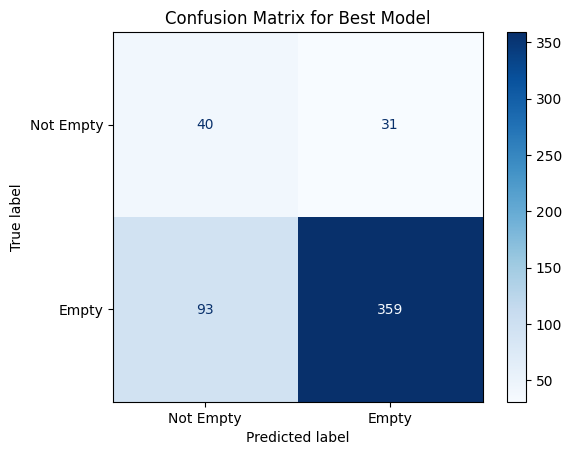

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot Confusion Matrix
def plot_confusion_matrix(true_bboxes, predicted_bboxes, predicted_labels, object_counts, iou_threshold=0.5):
    true_labels = []
    pred_labels = []

    for i in range(len(true_bboxes)):
        true_boxes = true_bboxes[i]
        pred_boxes = predicted_bboxes[i]
        pred_label_scores = predicted_labels[i]
        true_count = len(true_boxes)
        pred_count = object_counts[i]

        matched = np.zeros(true_count, dtype=bool)

        for j in range(pred_count):
            pred_box = pred_boxes[j]
            pred_label = int(pred_label_scores[j][0] >= 0.5)  # Binary label: 0 or 1

            best_iou = 0
            true_label = None
            for k in range(true_count):
                if matched[k]:
                    continue
                iou = calculate_iou(pred_box, true_boxes[k])
                if iou > best_iou:
                    best_iou = iou
                    true_label = k

            if best_iou >= iou_threshold and true_label is not None:
                matched[true_label] = True
                true_labels.append(1)  # True label is 'Empty'
                pred_labels.append(pred_label)
            else:
                pred_labels.append(pred_label)
                true_labels.append(0)  # Consider as false positive (no empty shelf)

    # Calculating and plotting the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Empty', 'Empty'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Best Model')
    plt.show()

# Define the category
categories = {0: 'Not Empty', 1: 'Empty'}

# Plotting the Confusion Matrix
plot_confusion_matrix(test_bboxes, bbox_predictions, class_predictions, object_counts)


### Classification Report
The model's classification performance using Precision, Recall and F1-Score is computed using the standard 0.5 threshold

In [25]:
import numpy as np
from sklearn.metrics import classification_report

# Function to generate the classification report
def generate_classification_report(true_bboxes, predicted_bboxes, predicted_labels, object_counts, iou_threshold=0.5):
    true_labels = []
    pred_labels = []

    for i in range(len(true_bboxes)):
        true_boxes = true_bboxes[i]
        pred_boxes = predicted_bboxes[i]
        pred_label_scores = predicted_labels[i]
        true_count = len(true_boxes)
        pred_count = object_counts[i]

        matched = np.zeros(true_count, dtype=bool)

        for j in range(pred_count):
            pred_box = pred_boxes[j]
            pred_label = int(pred_label_scores[j][0] >= 0.5)  # Binary label: 0 or 1

            best_iou = 0
            true_label = None
            for k in range(true_count):
                if matched[k]:
                    continue
                iou = calculate_iou(pred_box, true_boxes[k])
                if iou > best_iou:
                    best_iou = iou
                    true_label = k

            if best_iou >= iou_threshold and true_label is not None:
                matched[true_label] = True
                true_labels.append(1)  # True label is 'Empty'
                pred_labels.append(pred_label)
            else:
                pred_labels.append(pred_label)
                true_labels.append(0)  # Consider as false positive (no empty shelf)

    # Filtering out the unmatched predictions from the classification report
    valid_indices = [i for i in range(len(true_labels)) if true_labels[i] != -1]
    true_labels = [true_labels[i] for i in valid_indices]
    pred_labels = [pred_labels[i] for i in valid_indices]

    # Generating the classification report
    report = classification_report(true_labels, pred_labels, labels=[0, 1], target_names=['Not Empty', 'Empty'], output_dict=True)

    return report

# Generating the classification report
report = generate_classification_report(test_bboxes, bbox_predictions, class_predictions, object_counts)

# Displaying the classification report in table form
import pandas as pd

report_df = pd.DataFrame(report).transpose()

# Printing the dataframe as a table
print(report_df[['precision', 'recall', 'f1-score']].to_markdown())


|              |   precision |   recall |   f1-score |
|:-------------|------------:|---------:|-----------:|
| Not Empty    |    0.300752 | 0.56338  |   0.392157 |
| Empty        |    0.920513 | 0.794248 |   0.852732 |
| accuracy     |    0.762906 | 0.762906 |   0.762906 |
| macro avg    |    0.610632 | 0.678814 |   0.622444 |
| weighted avg |    0.836377 | 0.762906 |   0.790206 |
